Loading UCI HAR data from: /content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR
  Loaded body_acc_x: shape=(10299, 128)
  Loaded body_acc_y: shape=(10299, 128)
  Loaded body_acc_z: shape=(10299, 128)
  Loaded body_gyro_x: shape=(10299, 128)
  Loaded body_gyro_y: shape=(10299, 128)
  Loaded body_gyro_z: shape=(10299, 128)
  Loaded total_acc_x: shape=(10299, 128)
  Loaded total_acc_y: shape=(10299, 128)
  Loaded total_acc_z: shape=(10299, 128)
Stacked signals shape: (10299, 128, 9)
Transposed X shape (N, C, L): (10299, 9, 128)
Data scaling applied.
Loaded labels shape: (10299,)
Unique labels: [0 1 2 3 4 5]

Data loaded successfully. X shape: (10299, 9, 128), y shape: (10299,)
Input Channels: 9, Sequence Length: 128, Num Classes: 6

Data Split Shapes:
  Train: X=(6179, 9, 128), y=(6179,)
  Val:   X=(2060, 9, 128), y=(2060,)
  Test:  X=(2060, 9, 128), y=(2060,)

Class Weights (for training loss): [0.99693449 1.11213103 1.22018167 0.96607255 0.90020396 0.88321898]
DataLoaders created.

Mo

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 0.3226, Train Acc: 0.8836 | Val Loss: 0.1504, Val Acc: 0.9403
  -> Validation loss decreased to 0.1504. Saving model state.
Epoch 2/50 | Train Loss: 0.1589, Train Acc: 0.9380 | Val Loss: 0.1402, Val Acc: 0.9451
  -> Validation loss decreased to 0.1402. Saving model state.
Epoch 3/50 | Train Loss: 0.1347, Train Acc: 0.9435 | Val Loss: 0.1127, Val Acc: 0.9519
  -> Validation loss decreased to 0.1127. Saving model state.
Epoch 4/50 | Train Loss: 0.1538, Train Acc: 0.9409 | Val Loss: 0.1580, Val Acc: 0.9383
  -> Validation loss did not decrease for 1 epoch(s).
Epoch 5/50 | Train Loss: 0.1237, Train Acc: 0.9514 | Val Loss: 0.0990, Val Acc: 0.9578
  -> Validation loss decreased to 0.0990. Saving model state.
Epoch 6/50 | Train Loss: 0.1036, Train Acc: 0.9566 | Val Loss: 0.0973, Val Acc: 0.9587
  -> Validation loss decreased to 0.0973. Saving model state.
Epoch 7/50 | Train Loss: 0.0938, Train Acc: 0.9607 | Val Loss: 0.0912, Val Acc: 0.9612
  -> Validation loss decrea

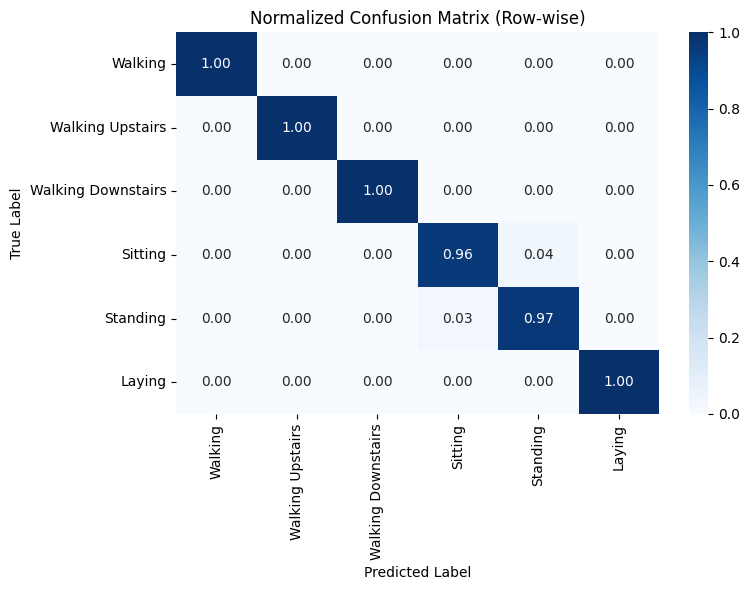

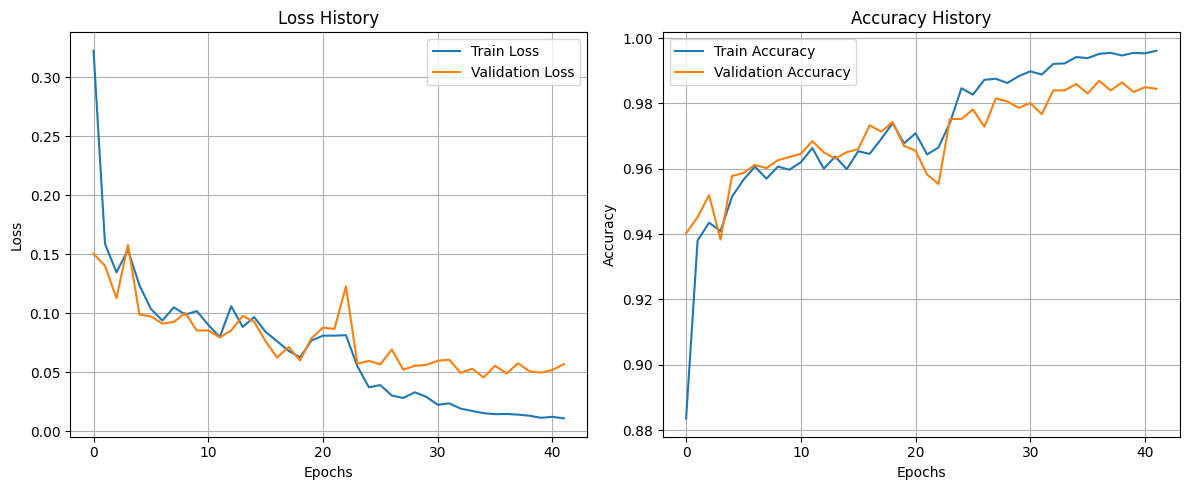


Final Test Accuracy: 0.9864


In [ ]:
import os
import numpy as np
import pandas as pd # Added for potential future use, though not strictly needed now
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # Added, useful for debugging labels if needed

# ==============================================================================
# Model Building Blocks (DepthwiseSeparableConv, MultiKernalBlock, etc.)
# ==============================================================================

# ---------------- Depthwise Separable Conv ----------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False): # Added bias parameter
        super().__init__()
        # Corrected padding logic if needed, but padding='same' might be simpler if supported or calculate manually
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# ---------------- MultiKernalBlock ----------------
class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Skip connection should match the final concatenated output channels (out_channels * 4)
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False) # Adjusted out_channels
        self.bn_skip = nn.BatchNorm1d(out_channels * 4) # Added BN for skip

        # Branches process sequentially in the original code, let's reflect that
        # Ensure padding keeps the sequence length the same if possible
        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3) # 7//2 = 3
        self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2) # 5//2 = 2
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1) # 3//2 = 1
        self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0) # 1//2 = 0

    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x)) # Apply BN to skip
        x7 = self.branch7(x)
        x5 = self.branch5(x7) # Takes output of previous branch
        x3 = self.branch3(x5) # Takes output of previous branch
        x1 = self.branch1(x3) # Takes output of previous branch

        # Concatenate the outputs of all branches
        out = torch.cat([x1, x3, x5, x7], dim=1) # Concatenate along channel dimension
        out = out + identity # Add skip connection
        return F.relu(out) # Apply ReLU after adding skip

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch): # Renamed for clarity
        super().__init__()
        total_out_channels = out_channels_per_branch * 4
        # Skip connection: Adjusted to match the concatenated output channels
        self.skip_proj = nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(total_out_channels) # Added BN for skip

        # Branch 1: 1x1 conv
        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)

        # Branch 2: 1x1 conv -> 3x3 conv
        self.branch3 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=3, padding=1)
        )

        # Branch 3: 1x1 conv -> 5x5 conv
        self.branch5 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            # Original uses 5x5, ensure padding keeps size same
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=5, padding=2)
        )

        # Branch 4: MaxPool -> 1x1 conv
        self.pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1), # Padding=1, Stride=1 keeps size same
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        )

    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x)) # Apply BN to skip
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1) # Concatenate along channel dimension
        out = out + identity # Add skip connection
        return F.relu(out) # Apply ReLU after skip

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        # Using standard Conv1d for Residual Block
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual # Add residual connection *before* final activation
        return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1): # Added dropout
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout) # Added dropout
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout), # Added dropout
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout) # Added dropout layers

    def forward(self, x):
        # Pre-Normalization variant (often more stable)
        x_norm1 = self.norm1(x)
        attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout(attn_out) # Apply dropout after attention

        x_norm2 = self.norm2(x)
        ffn_out = self.ffn(x_norm2)
        x = x + self.dropout(ffn_out) # Apply dropout after FFN
        return x

# ---------------- InceptionFormer ----------------
class InceptionFormer(nn.Module):
    def __init__(self, input_channels=9, feature_dim=64, num_classes=6, num_transformer_layers=2, num_heads=4, dropout=0.1): # Added params
        super().__init__()
        # Initial projection layer
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1, bias=False)
        self.input_bn = nn.BatchNorm1d(feature_dim)

        # Feature Extraction Blocks
        # InceptionBlock expects 'out_channels_per_branch'. If total output is feature_dim*4, then per_branch=feature_dim
        self.inception = InceptionBlock(feature_dim, feature_dim) # Output channels = feature_dim * 4
        # MultiKernalBlock expects 'out_channels'. If total output is feature_dim*4, then per_branch=feature_dim
        self.mkls = MultiKernalBlock(feature_dim * 4, feature_dim) # Input from Inception, output = feature_dim * 4

        # Residual Blocks for stabilization
        self.residual1 = ResidualBlock(feature_dim * 4) # After MKLs block

        # Transformer Layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(dim=feature_dim * 4, num_heads=num_heads, dropout=dropout)
            for _ in range(num_transformer_layers)
        ])

        # Classifier Head
        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim * 4), # Add LayerNorm before classifier
            nn.Linear(feature_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(dropout), # Dropout before final layer
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input x shape: (B, C_in, T) = (B, 9, 128) for UCI HAR
        x = F.relu(self.input_bn(self.input_proj(x))) # (B, feature_dim, T)

        # Feature extraction
        x = self.inception(x)   # (B, feature_dim*4, T)
        x = self.mkls(x)      # (B, feature_dim*4, T)
        x = self.residual1(x) # (B, feature_dim*4, T)

        # Transformer expects (B, T, C)
        x = x.permute(0, 2, 1) # (B, T, feature_dim*4)
        for layer in self.transformer_layers:
            x = layer(x)      # (B, T, feature_dim*4)

        # Global Average Pooling requires (B, C, T)
        x = x.permute(0, 2, 1) # (B, feature_dim*4, T)
        x = self.gap(x)       # (B, feature_dim*4, 1)
        x = self.flatten(x)   # (B, feature_dim*4)

        return self.classifier(x)

# ==============================================================================
# Data Loading and Dataset
# ==============================================================================
class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        # Data expected shape: (num_samples, num_channels, sequence_length)
        if data.ndim != 3:
             raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def load_uci_har_raw(dataset_path):
    """Loads UCI HAR raw inertial signals and labels."""
    print(f"Loading UCI HAR data from: {dataset_path}")
    SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
               "body_gyro_x", "body_gyro_y", "body_gyro_z",
               "total_acc_x", "total_acc_y", "total_acc_z"]
    X_list = []

    # Load train and test signals
    for signal in SIGNALS:
        train_file = os.path.join(dataset_path, "train", "Inertial Signals", f"{signal}_train.txt")
        test_file = os.path.join(dataset_path, "test", "Inertial Signals", f"{signal}_test.txt")
        try:
            train_signal = np.loadtxt(train_file, dtype=np.float32) # Use float32
            test_signal = np.loadtxt(test_file, dtype=np.float32)
            combined_signal = np.concatenate([train_signal, test_signal], axis=0)
            X_list.append(combined_signal)
            print(f"  Loaded {signal}: shape={combined_signal.shape}")
        except FileNotFoundError as e:
            print(f"Error loading file: {e}. Check dataset_path.")
            return None, None
        except Exception as e:
            print(f"An error occurred loading {signal}: {e}")
            return None, None

    if not X_list:
        print("No signal data loaded.")
        return None, None

    # Stack signals along a new axis (channels) -> (num_samples, sequence_length, num_channels)
    X = np.stack(X_list, axis=-1)
    print(f"Stacked signals shape: {X.shape}") # Should be (10299, 128, 9)

    # Transpose to (num_samples, num_channels, sequence_length) for Conv1D
    X = np.transpose(X, (0, 2, 1)) # -> (10299, 9, 128)
    print(f"Transposed X shape (N, C, L): {X.shape}")

    # --- Scaling ---
    # Scale each channel independently across all samples and time steps
    # Reshape to (N * L, C) for scaler
    num_samples, num_channels, seq_len = X.shape
    X_reshaped = X.transpose(0, 2, 1).reshape(-1, num_channels) # -> (N*L, C)
    scaler = StandardScaler()
    X_scaled_reshaped = scaler.fit_transform(X_reshaped)
    # Reshape back to (N, L, C) and then transpose to (N, C, L)
    X = X_scaled_reshaped.reshape(num_samples, seq_len, num_channels).transpose(0, 2, 1) # -> (N, C, L)
    print("Data scaling applied.")

    # Load labels
    try:
        y_train = np.loadtxt(os.path.join(dataset_path, "train", "y_train.txt"), dtype=int)
        y_test = np.loadtxt(os.path.join(dataset_path, "test", "y_test.txt"), dtype=int)
        y = np.concatenate([y_train, y_test], axis=0)
        # Adjust labels to be 0-indexed (original are 1-6)
        y = y - 1
        label_encoder = LabelEncoder() # Not strictly needed if already 0-5, but good practice
        y_encoded = label_encoder.fit_transform(y)
        print(f"Loaded labels shape: {y_encoded.shape}")
        print(f"Unique labels: {np.unique(y_encoded)}")
    except FileNotFoundError as e:
        print(f"Error loading label file: {e}. Check dataset_path.")
        return None, None
    except Exception as e:
        print(f"An error occurred loading labels: {e}")
        return None, None

    return X, y_encoded

# ==============================================================================
# Training and Evaluation Functions
# ==============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20, patience=5):
    """Trains and validates the model, includes early stopping."""
    print(f"\n=== Model Training Started (Device: {device}) ===")
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_state = None # Store the best model state

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Scheduler Step
        scheduler.step(epoch_val_loss)

        # Check for improvement and Early Stopping based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # Save the best model state
            best_model_state = model.state_dict()
            print(f"  -> Validation loss decreased to {best_val_loss:.4f}. Saving model state.")
        else:
            epochs_no_improve += 1
            print(f"  -> Validation loss did not decrease for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} consecutive epochs.")
                break

    print(f"=== Training Finished ===")
    if best_model_state:
        print(f"Loading best model state from epoch {best_epoch} with validation loss {best_val_loss:.4f}")
        model.load_state_dict(best_model_state)
    else:
        print("Warning: No best model state was saved (validation loss might not have improved).")

    return model, history


def evaluate_model(model, test_loader, criterion, device, class_names):
    """Evaluates the final model on the test dataset and plots a normalized confusion matrix."""
    print("\n=== Final Model Evaluation (Test Set) ===")
    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Loss 출력
    if criterion is not None and len(test_loader.dataset) > 0:
        test_loss = running_test_loss / len(test_loader.dataset)
        print(f"Test Loss: {test_loss:.4f}")
    else:
        test_loss = -1.0
        print("Test Loss: Not calculated")

    # Accuracy 출력
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    unique_labels = np.unique(all_labels)
    filtered_names = [class_names[i] for i in unique_labels if i < len(class_names)]
    print(classification_report(all_labels, all_preds, target_names=filtered_names, digits=4))

    # 정규화된 혼동 행렬 계산 (행 기준: True label별 비율)
    cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')

    # 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=filtered_names, yticklabels=filtered_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (Row-wise)')
    plt.tight_layout()
    plt.show()

    return test_loss, test_accuracy



# ==============================================================================
# Main Execution Block
# ==============================================================================
if __name__ == '__main__':
    # --- Configuration ---
    # !!! IMPORTANT: Set the correct path to the UCI HAR Dataset root folder !!!
    # This folder should contain 'train' and 'test' subfolders.
    UCI_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI-HAR'
    RANDOM_STATE = 42
    TEST_SPLIT_SIZE = 0.2  # Proportion of the dataset to use for the test set
    VAL_SPLIT_SIZE = 0.2   # Proportion of the non-test data to use for validation
    BATCH_SIZE = 64        # Reduced batch size slightly
    EPOCHS = 50            # Max epochs
    LEARNING_RATE = 0.001
    PATIENCE = 7           # Early stopping patience
    FEATURE_DIM = 128      # Increased feature dimension
    NUM_TRANSFORMER_LAYERS = 3 # Number of transformer layers
    NUM_HEADS = 8          # Number of attention heads
    DROPOUT = 0.2          # Dropout rate

    # Class names for UCI HAR dataset (1-6 mapped to 0-5)
    CLASS_NAMES = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    NUM_CLASSES = len(CLASS_NAMES)

    # Set seed for reproducibility
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_STATE)

    # --- 1. Load Data ---
    X, y = load_uci_har_raw(UCI_DATASET_PATH)

    if X is not None and y is not None:
        INPUT_CHANNELS = X.shape[1] # Should be 9
        SEQUENCE_LENGTH = X.shape[2] # Should be 128

        print(f"\nData loaded successfully. X shape: {X.shape}, y shape: {y.shape}")
        print(f"Input Channels: {INPUT_CHANNELS}, Sequence Length: {SEQUENCE_LENGTH}, Num Classes: {NUM_CLASSES}")

        # --- 2. Split Data (Train, Validation, Test) ---
        # First split: Separate Test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y
        )
        # Second split: Separate Train and Validation sets
        relative_val_size = VAL_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=relative_val_size, random_state=RANDOM_STATE, stratify=y_temp
        )

        print("\nData Split Shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

        # --- 3. Calculate Class Weights (using training set only) ---
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
        print(f"\nClass Weights (for training loss): {class_weights}")

        # --- 4. Create Datasets and DataLoaders ---
        train_dataset = UCIHARDataset(X_train, y_train)
        val_dataset = UCIHARDataset(X_val, y_val)
        test_dataset = UCIHARDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True) # Larger batch for validation
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True) # Larger batch for test
        print("DataLoaders created.")

        # --- 5. Initialize Model, Loss, Optimizer, Scheduler ---
        model = InceptionFormer(input_channels=INPUT_CHANNELS,
                                feature_dim=FEATURE_DIM,
                                num_classes=NUM_CLASSES,
                                num_transformer_layers=NUM_TRANSFORMER_LAYERS,
                                num_heads=NUM_HEADS,
                                dropout=DROPOUT)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        class_weights_tensor = class_weights_tensor.to(device) # Move weights to device

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01) # Using AdamW
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True) # Adjusted scheduler

        print(f"\nModel Initialized: {type(model).__name__}")
        print(f"Using device: {device}")

        # --- 6. Train the Model ---
        trained_model, history = train_model(model=model,
                                             train_loader=train_loader,
                                             val_loader=val_loader,
                                             criterion=criterion,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             device=device,
                                             epochs=EPOCHS,
                                             patience=PATIENCE)

        # --- 7. Evaluate the Final Model on Test Set ---
        # The 'trained_model' has the best validation weights loaded
        test_loss, test_accuracy = evaluate_model(model=trained_model,
                                                test_loader=test_loader,
                                                criterion=criterion, # Pass criterion here
                                                device=device,
                                                class_names=CLASS_NAMES)

        # --- 8. Plot Training History ---
        if history: # Check if history is not empty
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Loss History')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Accuracy')
            plt.plot(history['val_acc'], label='Validation Accuracy')
            plt.title('Accuracy History')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()
        else:
            print("\nNo history data to plot (Training might have been interrupted or finished at epoch 1).")

        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

    else:
        print("\nData loading failed. Exiting.")

성공적으로 데이터셋을 로드했습니다: /content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt
데이터 형태(Shape): (1086465, 6)

활동(Activity) 종류:
 activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64

윈도잉 시작 (Window Size: 150, Step: 75)...
윈도잉 완료: 총 14435 개의 윈도우 생성.

Data Split Shapes:
  Train: X=(8661, 150, 3), y=(8661,)
  Validation: X=(2887, 150, 3), y=(2887,)
  Test:  X=(2887, 150, 3), y=(2887,)

DataLoaders created.

=== 모델 학습 시작 (Device: cuda) ===
Epoch 1/50 | Train Loss: 0.6828, Train Acc: 0.7874 | Val Loss: 0.4036, Val Acc: 0.8483
  -> New best validation accuracy: 0.8483. Saving model state.
Epoch 2/50 | Train Loss: 0.2492, Train Acc: 0.9154 | Val Loss: 0.1720, Val Acc: 0.9439
  -> New best validation accuracy: 0.9439. Saving model state.
Epoch 3/50 | Train Loss: 0.1455, Train Acc: 0.9542 | Val Loss: 0.1270, Val Acc: 0.9543
  -> New best validation accuracy: 0.9543. Saving model state.
Epo

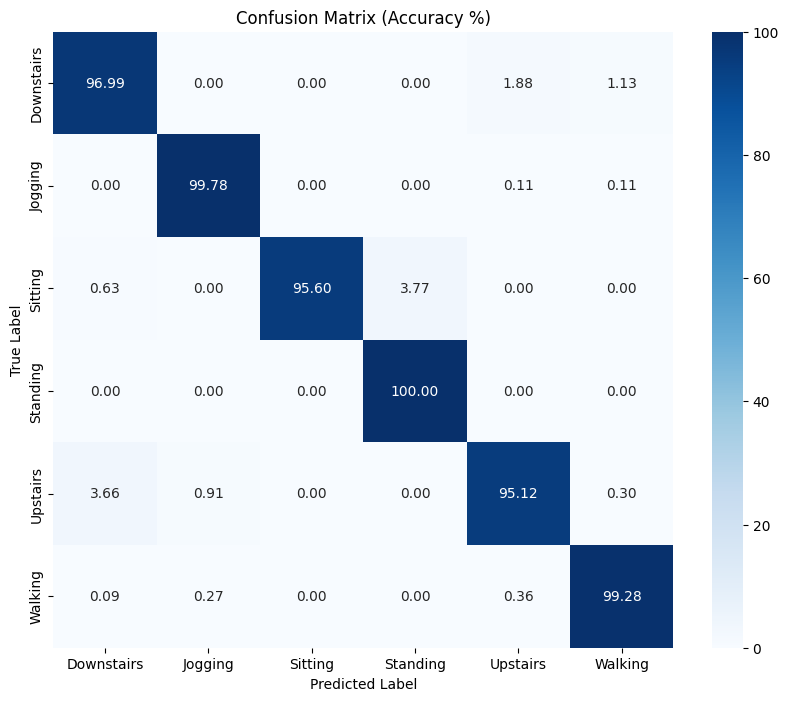

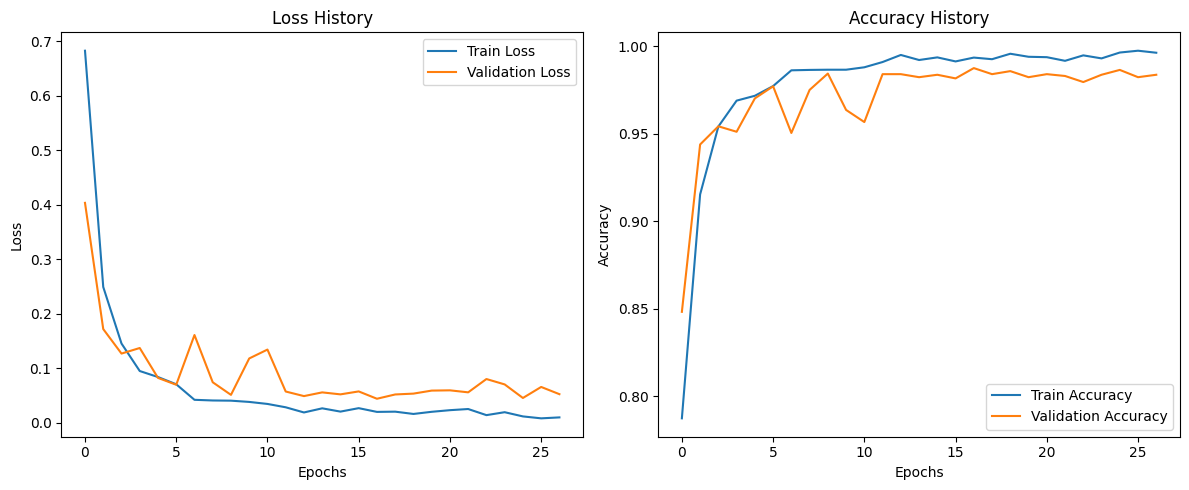

In [3]:


import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------- Depthwise Separable Conv ----------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# ---------------- MultiKernalBlock ----------------
class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3)
        self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        identity = self.skip_proj(x)
        x7 = self.branch7(x)
        x5 = self.branch5(x7)
        x3 = self.branch3(x5)
        x1 = self.branch1(x3)
        x1 = x1 + identity
        return torch.cat([x1, x3, x5, x7], dim=1)

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1)

        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=1, padding=0)

        self.branch3 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        )

        self.branch5 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        )

        self.pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=1, padding=0)
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1)
        identity = self.skip_proj(x)
        return out + identity

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

# ---------------- IncepFormer ----------------

class InceptionFormer(nn.Module):
    def __init__(self, input_channels=9, feature_dim=64, num_classes=2):
        super().__init__()
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1)
        self.residual1 = ResidualBlock(feature_dim)
        self.mkls = MultiKernalBlock(feature_dim, feature_dim)
        self.inception = InceptionBlock(feature_dim, feature_dim)
        self.reduce = nn.Sequential(
            nn.Conv1d(feature_dim * 8, feature_dim, kernel_size=1),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU()
        )
        self.residual2 = ResidualBlock(feature_dim)
        self.transformer = TransformerEncoderBlock(dim=feature_dim, num_heads=4)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x_proj = F.relu(self.input_proj(x))
        mk_out = self.mkls(x_proj)
        incep_out = self.inception(x_proj)
        concat = torch.cat([mk_out, incep_out], dim=1)
        reduced = self.reduce(concat)
        reduced = self.residual2(reduced)
        reduced = reduced.permute(0, 2, 1)  # (B, T, C)
        trans_out = self.transformer(reduced)
        fused = trans_out.mean(dim=1)
        return self.classifier(fused)



import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==============================================================================
# 1. 데이터 로드 함수 (제공된 함수)
# ==============================================================================
def load_wisdm_dataset(file_path):
    """
    WISDM (Wireless Sensor Data Mining) 원본 데이터셋 파일을 로드하고 기본적인 전처리를 수행합니다.
    (Provided function - slightly adapted timestamp type)
    """
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    if not os.path.exists(file_path):
        print(f"오류: 파일을 찾을 수 없습니다 - {file_path}")
        return None
    try:
        df = pd.read_csv(file_path, header=None, names=column_names, on_bad_lines='skip', engine='python')
        if df['z-axis'].dtype == 'object':
            df['z-axis'] = df['z-axis'].astype(str).str.rstrip(';')
        for col in ['timestamp', 'x-axis', 'y-axis', 'z-axis', 'user']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(inplace=True)
        df['user'] = df['user'].astype(int)
        # Use float64 for timestamp initially if it's very large, or int64
        df['timestamp'] = df['timestamp'].astype(np.int64)
        print(f"성공적으로 데이터셋을 로드했습니다: {file_path}")
        print(f"데이터 형태(Shape): {df.shape}")
        # print("\n처음 5개 행:\n", df.head())
        # print("\n데이터 타입:\n", df.dtypes)
        print("\n활동(Activity) 종류:\n", df['activity'].value_counts())
        return df
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다 - {file_path}")
        return None
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

# ==============================================================================
# 2. 데이터 전처리: 윈도잉 및 레이블 인코딩
# ==============================================================================
def create_windows(data_df, features, target_col, window_size, step):
    """
    시계열 데이터를 슬라이딩 윈도우 방식으로 자르고 레이블을 할당합니다.
    """
    X, y = [], []
    label_encoder = LabelEncoder()
    data_df[target_col + '_encoded'] = label_encoder.fit_transform(data_df[target_col])
    numeric_labels = data_df[target_col + '_encoded'].values
    class_names = label_encoder.classes_
    num_classes = len(class_names)

    print(f"\n윈도잉 시작 (Window Size: {window_size}, Step: {step})...")
    # 사용자별로 데이터를 분리하여 윈도잉 (사용자 경계를 넘지 않도록)
    grouped = data_df.groupby('user')
    total_windows = 0

    for user_id, group in grouped:
        sensor_data = group[features].values
        labels_for_user = group[target_col + '_encoded'].values
        start = 0
        while start + window_size <= len(sensor_data):
            window = sensor_data[start : start + window_size]
            # 윈도우 내 가장 빈번한 레이블 사용
            window_labels = labels_for_user[start : start + window_size]
            label_counts = Counter(window_labels)
            most_common_label = label_counts.most_common(1)[0][0]

            X.append(window)
            y.append(most_common_label)
            start += step
            total_windows += 1

    print(f"윈도잉 완료: 총 {total_windows} 개의 윈도우 생성.")
    if total_windows == 0:
         print("경고: 생성된 윈도우가 없습니다. Window Size나 Step을 확인하세요.")
         return None, None, None, None

    # (Num_Windows, Window_Size, Num_Features) 형태로 반환
    return np.array(X), np.array(y), class_names, num_classes

# ==============================================================================
# 3. PyTorch Dataset 클래스 정의
# ==============================================================================
class WISDMWindowDataset(Dataset):
    """WISDM 윈도우 데이터를 위한 PyTorch Dataset"""
    def __init__(self, X, y, transform=None):
        # 데이터 형태 확인: X should be [num_samples, sequence_length, num_features]
        if X.ndim != 3:
            raise ValueError(f"Input X must be 3-dimensional (samples, sequence, features), but got shape {X.shape}")

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) # CrossEntropyLoss expects Long type
        self.transform = transform # Optional: for augmentations

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = self.X[idx]
        y_item = self.y[idx]

        if self.transform:
            x_item = self.transform(x_item) # Apply transformations if any

        # 많은 Conv1D 모델은 [batch, channels, sequence_length] 형태를 기대함
        # 현재 데이터는 [sequence_length, num_features] 형태이므로 transpose 필요
        # 채널(feature) 수를 첫번째 차원으로 이동
        return x_item.permute(1, 0), y_item # Shape: [num_features, sequence_length], [label]


# ==============================================================================
# 5. 학습 및 평가 함수
# ==============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, patience=5):
    """모델 학습 및 검증 함수"""
    print(f"\n=== 모델 학습 시작 (Device: {device}) ===")
    best_val_accuracy = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Check for improvement and Early Stopping
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # Save the best model state
            best_model_state = model.state_dict()
            print(f"  -> New best validation accuracy: {best_val_accuracy:.4f}. Saving model state.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement for {patience} consecutive epochs.")
                break

    print(f"=== 학습 종료 ===")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at Epoch {best_epoch}")
    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    return model, history

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader, criterion, device, class_names):
    """테스트 데이터셋으로 최종 모델 평가 함수 (Normalized Confusion Matrix with Accuracy %)"""
    print("\n=== 최종 모델 평가 (Test Set) ===")
    model.eval()
    running_test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_test_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Normalized Confusion Matrix (Accuracy %)
    print("\nNormalized Confusion Matrix (Accuracy %):")
    cm = confusion_matrix(all_labels, all_preds, normalize='true') * 100  # 행별 정규화 후 % 변환

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Accuracy %)')
    plt.show()

    return test_loss, test_accuracy



# ==============================================================================
# 6. 메인 실행 로직
# ==============================================================================
if __name__ == '__main__':
    # --- Configuration ---
    # Google Colab 경로 예시, 실제 환경에 맞게 수정 필요
    DATASET_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt'
    FEATURES = ['x-axis', 'y-axis', 'z-axis'] # 사용할 센서 피처
    TARGET_COLUMN = 'activity'               # 예측할 타겟 컬럼

    # Windowing Parameters (조정 가능)
    WINDOW_SIZE = 150 # 윈도우 크기 (e.g., 20Hz * 7.5s = 150)
    STEP = 75         # 윈도우 이동 간격 (50% overlap)

    # Data Splitting Parameters
    VALIDATION_SIZE = 0.2 # 전체 데이터 중 검증 데이터 비율 (Train+Val 에서의 비율)
    TEST_SIZE = 0.2       # 전체 데이터 중 테스트 데이터 비율
    RANDOM_STATE = 42     # 재현성을 위한 시드

    # Training Parameters
    BATCH_SIZE = 128
    EPOCHS = 50           # 최대 에포크
    LEARNING_RATE = 0.001
    PATIENCE = 10         # Early stopping을 위한 patience

    # --- 1. Load Data ---
    raw_df = load_wisdm_dataset(DATASET_FILE_PATH)

    if raw_df is not None:
        # --- 2. Create Windowed Data ---
        X_windowed, y_windowed, CLASS_NAMES, NUM_CLASSES = create_windows(
            raw_df, FEATURES, TARGET_COLUMN, WINDOW_SIZE, STEP
        )

        if X_windowed is not None:
            NUM_FEATURES = X_windowed.shape[2] # Should be 3 for x,y,z
            SEQUENCE_LENGTH = X_windowed.shape[1] # Should be WINDOW_SIZE

            # --- 3. Split Data (Train, Validation, Test) ---
            # First split: Separate Test set
            X_temp, X_test, y_temp, y_test = train_test_split(
                X_windowed, y_windowed,
                test_size=TEST_SIZE,
                random_state=RANDOM_STATE,
                stratify=y_windowed
            )
            # Second split: Separate Train and Validation sets from the temporary set
            # Adjust validation size relative to the remaining data
            relative_val_size = VALIDATION_SIZE / (1.0 - TEST_SIZE)
            X_train, X_val, y_train, y_val = train_test_split(
                X_temp, y_temp,
                test_size=relative_val_size,
                random_state=RANDOM_STATE,
                stratify=y_temp
            )

            print(f"\nData Split Shapes:")
            print(f"  Train: X={X_train.shape}, y={y_train.shape}")
            print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
            print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

            # --- 4. Create Datasets and DataLoaders ---
            train_dataset = WISDMWindowDataset(X_train, y_train)
            val_dataset = WISDMWindowDataset(X_val, y_val)
            test_dataset = WISDMWindowDataset(X_test, y_test)

            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
            print("\nDataLoaders created.")

            # --- 5. Initialize Model, Loss, Optimizer ---
            # !!! 아래 라인을 실제 사용할 모델(예: MKIncepFormer)로 교체 !!!
            model = InceptionFormer(input_channels=NUM_FEATURES, num_classes=NUM_CLASSES)

            criterion = nn.CrossEntropyLoss() # 손실 함수
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # 옵티마이저

            # --- 6. Select Device ---
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device) # 모델을 해당 장치로 이동

            # --- 7. Train the Model ---
            trained_model, history = train_model(
                model, train_loader, val_loader, criterion, optimizer, device, epochs=EPOCHS, patience=PATIENCE
            )

            # --- 8. Evaluate the Final Model on Test Set ---
            # The 'trained_model' returned is the one with the best validation accuracy
            test_loss, test_accuracy = evaluate_model(
                trained_model, test_loader, criterion, device, CLASS_NAMES
            )

            # --- Optional: Plot Training History ---
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Loss History')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Accuracy')
            plt.plot(history['val_acc'], label='Validation Accuracy')
            plt.title('Accuracy History')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            print("윈도잉 과정에서 오류가 발생하여 학습을 진행할 수 없습니다.")
    else:
        print("데이터 로딩 실패로 인해 학습을 진행할 수 없습니다.")
